# RCT Results


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from flask import Flask
import os
import sys
import pandas as pd
from datetime import datetime, timedelta
from collections import defaultdict
import warnings
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from scipy import stats
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.db_session import init_db, session_scope
from src.data_manager.models import db, User 
from src.constants import DATABASE_FILENAME, DATA_FOLDER_NAME
from src.db_session import init_db
from src.data_manager.user import *
from src.data_manager.meal import get_all_meals

### Initializing DB - necessary to use functions for analysis

In [3]:
app = Flask(__name__)

base_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
database_directory = os.path.join(base_directory, DATA_FOLDER_NAME)
database_path = os.path.join(database_directory, DATABASE_FILENAME)
complete_path = 'sqlite:///' +  database_path

app.config['SQLALCHEMY_DATABASE_URI'] = complete_path
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False

db.init_app(app)  
init_db(complete_path)

## 1. Demographics - Age, Gender, Language (N = 112)


In [4]:
def preprocessing_users_and_meals():
    """Preprocess user and meal data to use for analyis"""
    with app.app_context():
        users = get_all_users()
        all_normal_users = []
        #for user in users :
        #    if user.study_ended == True or (user.withdrawal == True and user.study_ended == False):
        #        all_normal_users.append(user)
        meals = get_all_meals(datetime_sort=True)
        #users = all_normal_users

    users_df = pd.DataFrame([{
        'user_id': user.id if hasattr(user, 'id') else getattr(user, 'user_id', i),
        'study_group': user.study_group,
        'gender': user.gender,
        'withdrawal': user.withdrawal,
        'language': user.language,
        'age': user.age
    } for i, user in enumerate(users)])

    meals_df = pd.DataFrame([{
        'user_id': meal.user_id,
        'datetime': meal.datetime,
        'nutrients': meal.nutrients,
        'id': meal.id
    } for meal in meals])

    meals_df['datetime'] = pd.to_datetime(meals_df['datetime'])
    return users_df, meals_df

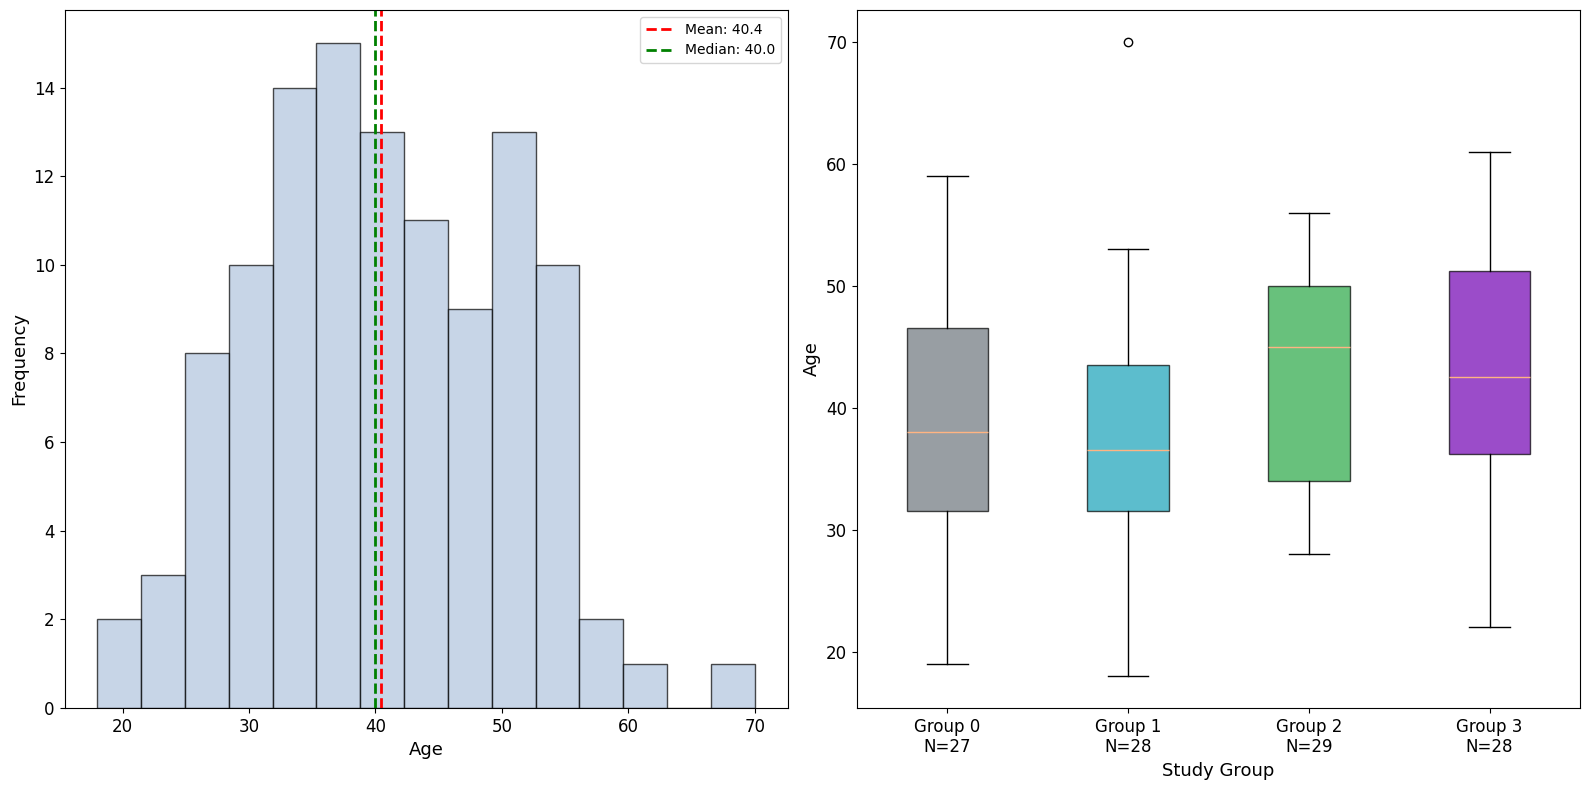

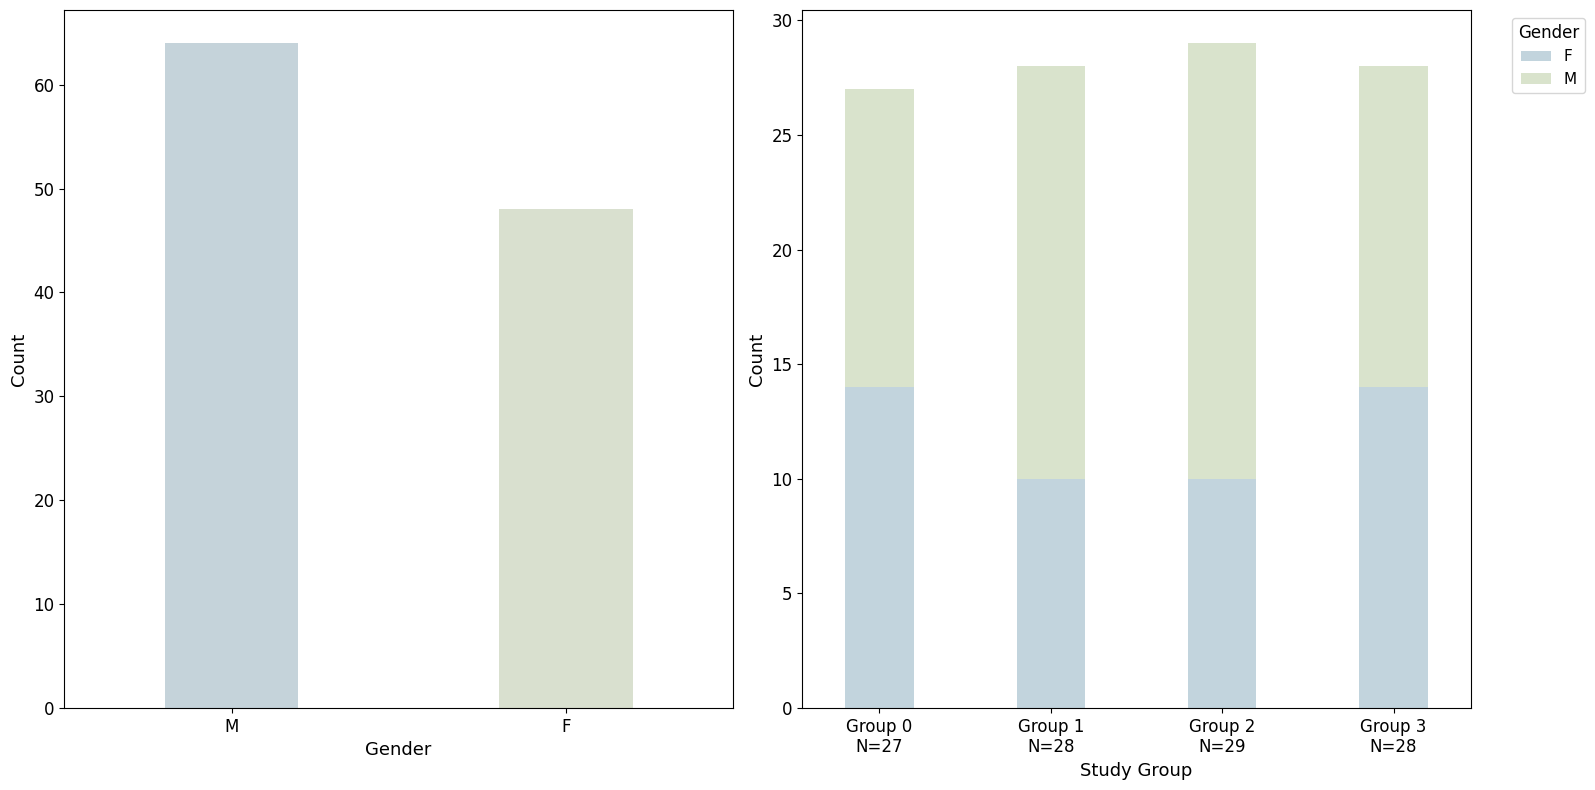

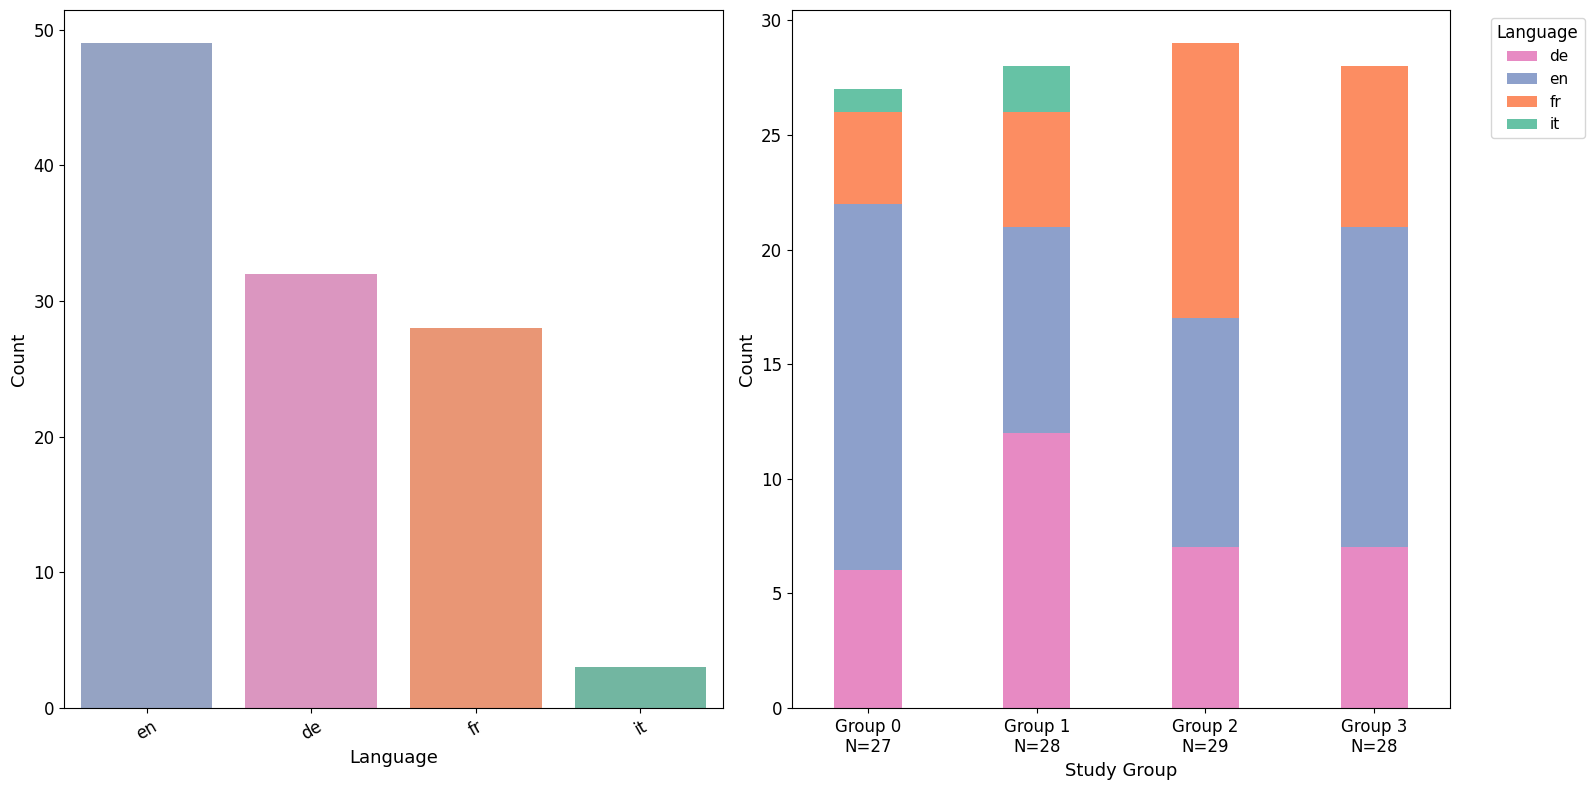

In [5]:
users_df, meals_df = preprocessing_users_and_meals() 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === SETTINGS ===
plt.style.use('default')
sns.set_palette("pastel")
colors = ['#6c757d', '#17a2b8', '#28a745', '#7100b3']

# Stats
mean_age = users_df['age'].mean()
median_age = users_df['age'].median()
group_counts = users_df['study_group'].value_counts().sort_index()
study_groups = sorted(users_df['study_group'].unique())

# Median ages per group
median_ages_by_group = users_df.groupby('study_group')['age'].median()

# === AGE PLOTS ===
fig = plt.figure(figsize=(16, 8))

# 1. Histogram with mean & median
plt.subplot(1, 2, 1)
plt.hist(users_df['age'], bins=15, alpha=0.7, color='lightsteelblue', edgecolor='black')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.1f}')
plt.xlabel('Age', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=12)

# 2. Box plot per study group
plt.subplot(1, 2, 2)
box_data = [users_df[users_df['study_group'] == group]['age'].values for group in study_groups]
labels_with_counts = [f'Group {group}\nN={group_counts[group]}' for group in study_groups]
bp = plt.boxplot(box_data, labels=labels_with_counts, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.xlabel('Study Group', fontsize=13)
plt.ylabel('Age', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

# === GENDER PLOTS ===
fig = plt.figure(figsize=(16, 8))
gender_colors = ['#c2d4dd', '#d9e3cc', '#f1d9e0']

# 3. Overall Gender Distribution
plt.subplot(1, 2, 1)
gender_counts = users_df['gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=gender_colors[:len(gender_counts)], width=0.4)
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

# 4. Gender Distribution by Study Group (Stacked bar)
plt.subplot(1, 2, 2)
gender_group_crosstab = pd.crosstab(users_df['study_group'], users_df['gender'])
gender_group_crosstab.index = [f'Group {group}\nN={group_counts[group]}' for group in gender_group_crosstab.index]
gender_group_crosstab.plot(kind='bar', stacked=True, ax=plt.gca(), 
                           color=gender_colors[:len(gender_group_crosstab.columns)],width=0.4)
plt.xlabel('Study Group', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

# === LANGUAGE PLOTS ===
fig = plt.figure(figsize=(16, 8))

language_list = users_df['language'].unique()
language_palette = sns.color_palette("Set2", n_colors=len(language_list))
language_colors = dict(zip(language_list, language_palette))

# 5. Overall Language Distribution
plt.subplot(1, 2, 1)
language_counts = users_df['language'].value_counts()
sns.barplot(x=language_counts.index, y=language_counts.values, palette=[language_colors[lang] for lang in language_counts.index])
plt.xlabel('Language', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=30)
plt.tick_params(axis='both', which='major', labelsize=12)

# 6. Language Distribution by Study Group (Stacked bar)
plt.subplot(1, 2, 2)
language_group_crosstab = pd.crosstab(users_df['study_group'], users_df['language'])
language_group_crosstab.index = [f'Group {group}\nN={group_counts[group]}' for group in language_group_crosstab.index]
language_group_crosstab.plot(kind='bar', stacked=True, ax=plt.gca(), 
                             color=[language_colors[lang] for lang in language_group_crosstab.columns],width=0.4)
plt.xlabel('Study Group', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


## 2 - App intake : General initiation levels

### 2.1 - Overall app intake per study group

Adherence Summary by Study Group:
             Total_Users  Users_Started  Adherence_Rate  Non_Adherent
study_group                                                          
0                     27             14        0.518519            13
1                     28             19        0.678571             9
2                     29             21        0.724138             8
3                     28             25        0.892857             3

Contingency Table:
 started_tracking  False  True 
study_group                   
0                    13     14
1                     9     19
2                     8     21
3                     3     25

Overall Chi-square test:
  Chi2 statistic = 9.4175
  Degrees of freedom = 3
  p-value = 0.0242
  Effect size (Cramér's V) = 0.2900

Pairwise Fisher's Exact Tests with Holm Correction:
Group 0 vs Group 1:
  p-value (uncorrected) = 0.2772
  p-value (corrected) = 0.6705
  Significant after correction: No
  Odds Ratio = 1.96 (95% CI: 0.66 -

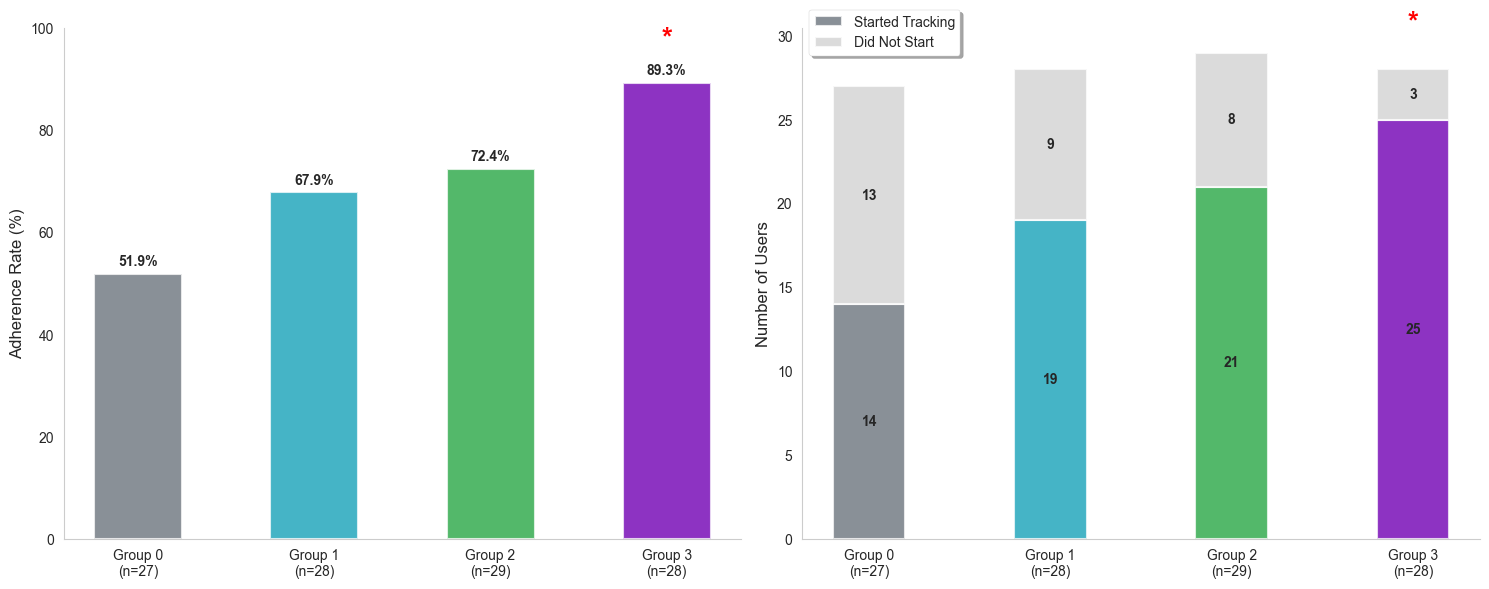


DETAILED ADHERENCE ANALYSIS SUMMARY

Group 0:
  Total participants: 27
  Started tracking: 14
  Did not start: 13
  Adherence rate: 51.9%

Group 1:
  Total participants: 28
  Started tracking: 19
  Did not start: 9
  Adherence rate: 67.9%

Group 2:
  Total participants: 29
  Started tracking: 21
  Did not start: 8
  Adherence rate: 72.4%

Group 3:
  Total participants: 28
  Started tracking: 25
  Did not start: 3
  Adherence rate: 89.3%

Overall adherence rate: 70.5%
Total participants: 112
Participants who started: 79

PAIRWISE STATISTICAL COMPARISONS SUMMARY
Significant differences found between:
  Group 0 vs Group 3: p = 0.0030, OR = 7.7381

Note: Using Fisher's exact test for pairwise comparisons (α = 0.05)
Total comparisons performed: 6


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
from itertools import combinations
from statsmodels.stats.multitest import multipletests

users_df, meals_df = preprocessing_users_and_meals()

users_with_meals = meals_df['user_id'].unique()
users_df['started_tracking'] = users_df['user_id'].isin(users_with_meals)

adherence_summary = users_df.groupby('study_group').agg(
    Total_Users=('started_tracking', 'count'),
    Users_Started=('started_tracking', 'sum')
)
adherence_summary['Adherence_Rate'] = adherence_summary['Users_Started'] / adherence_summary['Total_Users']
adherence_summary['Non_Adherent'] = adherence_summary['Total_Users'] - adherence_summary['Users_Started']

print("Adherence Summary by Study Group:")
print(adherence_summary)

# --- Overall test: Chi-square ---
contingency_table = pd.crosstab(users_df['study_group'], users_df['started_tracking'])
print("\nContingency Table:\n", contingency_table)

chi2, p_overall, dof, expected = chi2_contingency(contingency_table)

# Calculate Cramer's V for effect size
n = contingency_table.values.sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"\nOverall Chi-square test:")
print(f"  Chi2 statistic = {chi2:.4f}")
print(f"  Degrees of freedom = {dof}")
print(f"  p-value = {p_overall:.4f}")
print(f"  Effect size (Cramér's V) = {cramers_v:.4f}")

# --- Pairwise comparisons ---
groups = sorted(users_df['study_group'].unique())
pairwise_results = {}
pair_keys = []
pvals = []

# uncorrected p-values first
for g1, g2 in combinations(groups, 2):
    sub_df = users_df[users_df['study_group'].isin([g1, g2])]
    ct = pd.crosstab(sub_df['study_group'], sub_df['started_tracking'])
    
    if ct.shape == (2, 2):
        odds_ratio, p_val = fisher_exact(ct)
        
        # Calculate 95% CI for OR (using Woolf's method)
        a = ct.iloc[0,1]  # group1 started
        b = ct.iloc[0,0]  # group1 not started
        c = ct.iloc[1,1]  # group2 started
        d = ct.iloc[1,0]  # group2 not started

        # Apply 0.5 correction if needed to avoid division by zero
        a_adj, b_adj, c_adj, d_adj = [x if x > 0 else 0.5 for x in (a,b,c,d)]

        se_log_or = np.sqrt(1/a_adj + 1/b_adj + 1/c_adj + 1/d_adj)
        log_or = np.log(odds_ratio) if odds_ratio > 0 else 0
        ci_lower = np.exp(log_or - 1.96 * se_log_or)
        ci_upper = np.exp(log_or + 1.96 * se_log_or)

        key = f"Group {g1} vs Group {g2}"
        pairwise_results[key] = {
            'p_value': p_val,
            'odds_ratio': odds_ratio,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
        pair_keys.append(key)
        pvals.append(p_val)

# !!! APPLY CORRECTION (HOLM) !!!
rejects, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='holm')

# Add corrected p-values and significance to the dictionary
for i, key in enumerate(pair_keys):
    pairwise_results[key]['p_value_corrected'] = pvals_corrected[i]
    pairwise_results[key]['significant'] = rejects[i]

# Print nicely just to have an idea within the notebook
print("\nPairwise Fisher's Exact Tests with Holm Correction:")
for key, res in pairwise_results.items():
    print(f"{key}:")
    print(f"  p-value (uncorrected) = {res['p_value']:.4f}")
    print(f"  p-value (corrected) = {res['p_value_corrected']:.4f}")
    print(f"  Significant after correction: {'Yes' if res['significant'] else 'No'}")
    print(f"  Odds Ratio = {res['odds_ratio']:.2f} (95% CI: {res['ci_lower']:.2f} - {res['ci_upper']:.2f})\n")
    print()

# --- Visualization ---
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['axes.linewidth'] = 0.8

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

group_colors = ['#6c757d', '#17a2b8', '#28a745', '#7100b3']

# Determine which groups are significantly different from control (Group 0)
significant_vs_control = []
for group in groups:
    if group != 0: 
        comparison_key = f"Group 0 vs Group {group}"
        if comparison_key in pairwise_results and pairwise_results[comparison_key]['significant']:
            significant_vs_control.append(group)

# Create x-axis labels with sample sizes
x_labels = []
for group in groups:
    sample_size = adherence_summary.loc[group, 'Total_Users']
    x_labels.append(f'Group {group}\n(n={sample_size})')

# 1. Adherence Rate by Group (Bar Chart)
ax1 = axes[0]
adherence_rates = [adherence_summary.loc[group, 'Adherence_Rate'] * 100 for group in groups]
bars = ax1.bar(x_labels, adherence_rates, 
               color=[group_colors[group] for group in groups], 
               alpha=0.8, edgecolor='white', linewidth=1.5, width=0.5)

# Add percentage labels on bars
for bar, rate in zip(bars, adherence_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add significance indicators (asterisks) for groups significantly different from control
for i, group in enumerate(groups):
    if group in significant_vs_control:
        ax1.text(bars[i].get_x() + bars[i].get_width()/2., bars[i].get_height() + 6,
                 '*', ha='center', va='bottom', fontsize=20, fontweight='bold', color='red')

ax1.set_ylabel('Adherence Rate (%)', fontsize=12)
ax1.set_ylim(0, 100)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#CCCCCC')
ax1.spines['bottom'].set_color('#CCCCCC')

# 2. Stacked Bar Chart (Adherent vs Non-Adherent)
ax2 = axes[1]
width = 0.4
bottom_vals = [adherence_summary.loc[group, 'Users_Started'] for group in groups]
top_vals = [adherence_summary.loc[group, 'Non_Adherent'] for group in groups]

bars1 = ax2.bar(x_labels, bottom_vals, width, 
                label='Started Tracking', color=[group_colors[group] for group in groups], 
                alpha=0.8, edgecolor='white', linewidth=1.5)
bars2 = ax2.bar(x_labels, top_vals, width, 
                bottom=bottom_vals, label='Did Not Start', color='lightgray', 
                alpha=0.8, edgecolor='white', linewidth=1.5)

# Add count labels
for i, (bar1, bar2, group) in enumerate(zip(bars1, bars2, groups)):
    # Started tracking count
    if bottom_vals[i] > 0:
        ax2.text(bar1.get_x() + bar1.get_width()/2., bottom_vals[i]/2,
                 str(int(bottom_vals[i])), ha='center', va='center', fontweight='bold', fontsize=10)
    # Did not start count
    if top_vals[i] > 0:
        ax2.text(bar2.get_x() + bar2.get_width()/2., bottom_vals[i] + top_vals[i]/2,
                 str(int(top_vals[i])), ha='center', va='center', fontweight='bold', fontsize=10)

# Add significance indicators (asterisks) for groups significantly different from control
for i, group in enumerate(groups):
    if group in significant_vs_control:
        total_height = bottom_vals[i] + top_vals[i]
        ax2.text(bars1[i].get_x() + bars1[i].get_width()/2., total_height + 2,
                 '*', ha='center', va='bottom', fontsize=20, fontweight='bold', color='red')

ax2.set_ylabel('Number of Users', fontsize=12)
ax2.legend(frameon=True, fancybox=True, shadow=True, bbox_to_anchor = (0,1.05), loc='upper left')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#CCCCCC')
ax2.spines['bottom'].set_color('#CCCCCC')


plt.tight_layout()
plt.show()

# Print detailed summary - for us to have an idea of whats it looks like
print("\n" + "="*60)
print("DETAILED ADHERENCE ANALYSIS SUMMARY")
print("="*60)

for group in groups:
    group_data = users_df[users_df['study_group'] == group]
    started = group_data['started_tracking'].sum()
    total = len(group_data)
    rate = started / total * 100
    
    print(f"\nGroup {group}:")
    print(f"  Total participants: {total}")
    print(f"  Started tracking: {started}")
    print(f"  Did not start: {total - started}")
    print(f"  Adherence rate: {rate:.1f}%")

print(f"\nOverall adherence rate: {users_df['started_tracking'].mean()*100:.1f}%")
print(f"Total participants: {len(users_df)}")
print(f"Participants who started: {users_df['started_tracking'].sum()}")

# Statistical summary
print("\n" + "="*60)
print("PAIRWISE STATISTICAL COMPARISONS SUMMARY")
print("="*60)

significant_comparisons = [comp for comp, result in pairwise_results.items() if result['significant']]

if significant_comparisons:
    print("Significant differences found between:")
    for comp in significant_comparisons:
        p_val = pairwise_results[comp]['p_value']
        odds_ratio = pairwise_results[comp]['odds_ratio']
        print(f"  {comp}: p = {p_val:.4f}, OR = {odds_ratio:.4f}")
else:
    print("No significant differences found between any group pairs.")

print(f"\nNote: Using Fisher's exact test for pairwise comparisons (α = 0.05)")
print(f"Total comparisons performed: {len(pairwise_results)}")

### 2.2 - Rapidity of app intake per study group --> Cumulative probability of using the app, against time since randomisation

Processed ITT 'time to first use' data for 112 users.
Users who logged at least one meal: 79
Users who never logged a meal: 33

Summary by study group:
            first_meal_logged     duration
                        count sum     mean
study_group                               
0                          27  14     7.22
1                          28  19     5.17
2                          29  21     5.59
3                          28  25     1.99


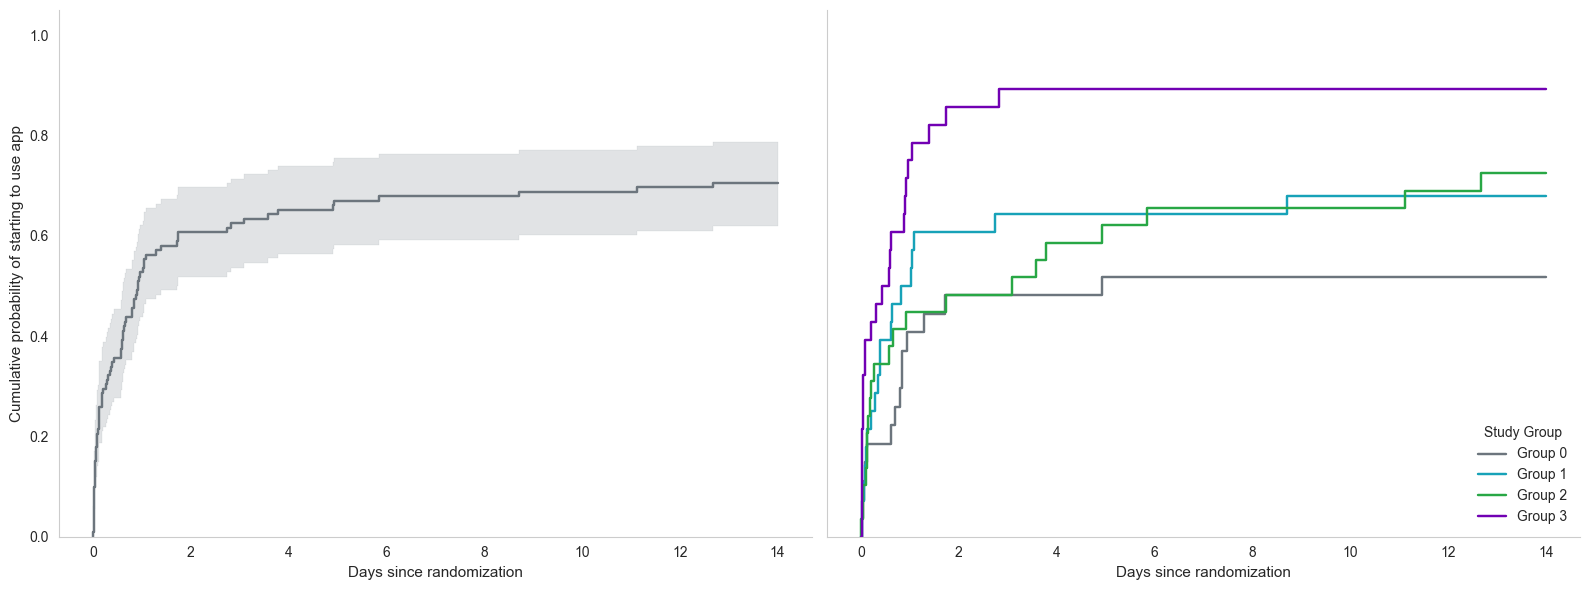


STATISTICAL ANALYSIS - TIME TO FIRST USE

Overall Statistics:
Total randomized users: 112
Users who started using app: 79 (70.5%)
Users who never started: 33 (29.5%)
Median time to first use: 0.9 days

By Study Group:
Group 0: 14/27 started (51.9%)
  Median time to first use: 4.9 days
Group 1: 19/28 started (67.9%)
  Median time to first use: 0.8 days
Group 2: 21/29 started (72.4%)
  Median time to first use: 3.1 days
Group 3: 25/28 started (89.3%)
  Median time to first use: 0.4 days

Log-rank tests:
------------------------------
Overall comparison (all groups):
Note: Use multivariate_logrank_test for overall comparison of >2 groups
Performing pairwise comparisons instead:

  Hazard Ratio (Group 1 / Group 0): 1.568 [95% CI: 0.785–3.133]
Group 0 vs Group 1:
  Test statistic: 1.6479
  p-value: 0.1992
  Significant (α=0.05): No

  Hazard Ratio (Group 2 / Group 0): 1.562 [95% CI: 0.793–3.075]
Group 0 vs Group 2:
  Test statistic: 1.6932
  p-value: 0.1932
  Significant (α=0.05): No

  Ha

In [9]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

# !!!!! Create a mapping from user_id to randomization date !!!!!
batch_dates = {
    **dict.fromkeys(range(1, 53), pd.Timestamp('2025-06-12 17:33')),
    **dict.fromkeys(range(53, 90), pd.Timestamp('2025-06-16 11:30')),
    **dict.fromkeys(range(90, 108), pd.Timestamp('2025-06-18 09:57')),
    **dict.fromkeys(range(108, 113), pd.Timestamp('2025-06-19 11:08')),
}

records = []
STUDY_DURATION_DAYS = 14
for _, user in users_df.iterrows():
    uid = user['user_id']
    group = user['study_group']
    withdrawal = user['withdrawal']

    randomization_date = batch_dates.get(uid)
    if randomization_date is None:
        print(f"Warning: user_id {uid} has no randomization date, skipping.")
        continue

    study_start = randomization_date
    study_end = study_start + pd.Timedelta(days=STUDY_DURATION_DAYS)

    user_meals = meals_df[meals_df['user_id'] == uid].sort_values('datetime')
    
    if len(user_meals) == 0:
        duration = (study_end - study_start).total_seconds() / (3600*24)
        event_occurred = 0  # we censor them
        
        records.append({
            'user_id': uid,
            'duration': duration,
            'event': event_occurred,
            'study_group': group,
            'withdrawal': withdrawal,
            'first_meal_logged': False
        })
        continue

    first_meal_time = user_meals['datetime'].iloc[0]
    
    if first_meal_time <= study_end:
        duration = (first_meal_time - study_start).total_seconds() / (3600*24)
        event_occurred = 1
        
        records.append({
            'user_id': uid,
            'duration': duration,
            'event': event_occurred,
            'study_group': group,
            'withdrawal': withdrawal,
            'first_meal_logged': True
        })
    else:
        duration = (study_end - study_start).total_seconds() / (3600*24)
        event_occurred = 0
        
        records.append({
            'user_id': uid,
            'duration': duration,
            'event': event_occurred,
            'study_group': group,
            'withdrawal': withdrawal,
            'first_meal_logged': False
        })

survival_df = pd.DataFrame.from_records(records)

print(f"Processed ITT 'time to first use' data for {len(survival_df)} users.")
print(f"Users who logged at least one meal: {survival_df['first_meal_logged'].sum()}")
print(f"Users who never logged a meal: {(~survival_df['first_meal_logged']).sum()}")
print("\nSummary by study group:")
print(survival_df.groupby('study_group').agg({
    'first_meal_logged': ['count', 'sum'],
    'duration': 'mean'
}).round(2))

# ------------------------
# PLOTTING (Probability of USING the app)
# ------------------------
kmf = KaplanMeierFitter()
groups = sorted(survival_df['study_group'].unique())
colors = ['#6c757d', '#17a2b8', '#28a745', '#7100b3']

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)


kmf.fit(survival_df['duration'], event_observed=survival_df['event'], label='All Users')
cum_incidence = 1 - kmf.survival_function_

axes[0].plot(
    cum_incidence.index, cum_incidence.values, 
    color=colors[0], label='All Users',
    drawstyle='steps-post'
)
axes[0].fill_between(
    cum_incidence.index,
    1 - kmf.confidence_interval_['All Users_upper_0.95'],
    1 - kmf.confidence_interval_['All Users_lower_0.95'],
    color=colors[0],
    alpha=0.2,
    step='post'
)
axes[0].set_xlabel('Days since randomization')
axes[0].set_ylabel('Cumulative probability of starting to use app')
axes[0].set_ylim(0, 1.05)

# Cumulative incidence by study group
for group, color in zip(groups, colors):
    mask = survival_df['study_group'] == group
    kmf.fit(survival_df.loc[mask, 'duration'], survival_df.loc[mask, 'event'], label=f'Group {group}')
    cum_incidence = 1 - kmf.survival_function_
    
    axes[1].plot(
        cum_incidence.index, cum_incidence.values,
        color=color, label=f'Group {group}',
        drawstyle='steps-post'
    )
axes[1].set_xlabel('Days since randomization')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1.05)
axes[1].legend(title='Study Group')

plt.tight_layout()
plt.show()

# ------------------------
# STATISTICAL TESTS
# ------------------------
print("\n" + "="*50)
print("STATISTICAL ANALYSIS - TIME TO FIRST USE")
print("="*50)

total_users = len(survival_df)
users_started = survival_df['event'].sum()
never_started = total_users - users_started

print(f"\nOverall Statistics:")
print(f"Total randomized users: {total_users}")
print(f"Users who started using app: {users_started} ({users_started/total_users*100:.1f}%)")
print(f"Users who never started: {never_started} ({never_started/total_users*100:.1f}%)")

kmf_overall = KaplanMeierFitter()
kmf_overall.fit(survival_df['duration'], survival_df['event'])
median_time = kmf_overall.median_survival_time_
print(f"Median time to first use: {median_time:.1f} days" if not pd.isna(median_time) else "Median time to first use: Not reached")

print(f"\nBy Study Group:")
for group in groups:
    group_data = survival_df[survival_df['study_group'] == group]
    group_total = len(group_data)
    group_started = group_data['event'].sum()
    
    kmf_group = KaplanMeierFitter()
    kmf_group.fit(group_data['duration'], group_data['event'])
    group_median = kmf_group.median_survival_time_
    
    print(f"Group {group}: {group_started}/{group_total} started ({group_started/group_total*100:.1f}%)")
    print(f"  Median time to first use: {group_median:.1f} days" if not pd.isna(group_median) else f"  Median time to first use: Not reached")

# Log-rank tests for our groupssss
if len(groups) > 1:
    from lifelines.statistics import logrank_test
    from itertools import combinations
    
    print(f"\nLog-rank tests:")
    print("-" * 30)
    
    if len(groups) > 2:
        print("Overall comparison (all groups):")
        print("Note: Use multivariate_logrank_test for overall comparison of >2 groups")
        print("Performing pairwise comparisons instead:\n")
    
    p_values = []
    comparisons = []
    
    for group1, group2 in combinations(groups, 2):
        group1_data = survival_df[survival_df['study_group'] == group1]
        group2_data = survival_df[survival_df['study_group'] == group2]
        
        results = logrank_test(
            group1_data['duration'], group2_data['duration'],
            event_observed_A=group1_data['event'], event_observed_B=group2_data['event'],
            alpha=0.05
        )

        pair_df = pd.concat([group1_data, group2_data])
        pair_df = pair_df.copy()
        pair_df['comparison_group'] = (pair_df['study_group'] == group2).astype(int) 

        cph = CoxPHFitter()
        cph.fit(pair_df[['duration', 'event', 'comparison_group']], duration_col='duration', event_col='event')

        ci = np.exp(cph.confidence_intervals_.loc['comparison_group'])
        hr = np.exp(cph.params_['comparison_group'])

        print(f"  Hazard Ratio (Group {group2} / Group {group1}): {hr:.3f} [95% CI: {ci[0]:.3f}–{ci[1]:.3f}]")
        
        p_values.append(results.p_value)
        comparisons.append(f"Group {group1} vs Group {group2}")
        
        print(f"Group {group1} vs Group {group2}:")
        print(f"  Test statistic: {results.test_statistic:.4f}")
        print(f"  p-value: {results.p_value:.4f}")
        print(f"  Significant (α=0.05): {'Yes' if results.p_value < 0.05 else 'No'}\n")
    
    #!!!!! Multiple comparison correction (Holm) !!!!!
    if len(p_values) > 1:
        print("Multiple comparison correction (Holm):")
        sorted_indices = np.argsort(p_values)
        sorted_pvals = np.array(p_values)[sorted_indices]
        sorted_comparisons = np.array(comparisons)[sorted_indices]
        
        m = len(sorted_pvals)
        significant = []
        
        for k, (p_val, comparison) in enumerate(zip(sorted_pvals, sorted_comparisons), start=1):
            adjusted_alpha = 0.05 / (m - k + 1)
            if p_val < adjusted_alpha:
                significant.append((comparison, p_val))
        
        if significant:
            print("Significant comparisons after Holm correction:")
            for comparison, p_val in significant:
                print(f"  {comparison}: p = {p_val:.4f} *")
        else:
            print("  None")
        print()

# Additional cumulative usage stats
print("="*50)
print("DETAILED CUMULATIVE USAGE STATISTICS BY GROUP")
print("="*50)

for group in groups:
    group_data = survival_df[survival_df['study_group'] == group]
    print(f"\nGroup {group}:")
    print(f"  n = {len(group_data)}")
    print(f"  Events (started using): {group_data['event'].sum()}")
    print(f"  Censored (never started): {(1 - group_data['event']).sum()}")
    
    kmf_group = KaplanMeierFitter()
    kmf_group.fit(group_data['duration'], group_data['event'])
    
    time_points = [1, 3, 7, 14, 30]
    
    print(f"  Median time to first use: {kmf_group.median_survival_time_:.1f} days" if not pd.isna(kmf_group.median_survival_time_) else f"  Median time to first use: Not reached")
    
    print(f"  Probability of HAVING started by day:")
    for t in time_points:
        if t <= group_data['duration'].max():
            prob_not_started = kmf_group.survival_function_at_times(t).iloc[0]
            prob_started = 1 - prob_not_started
            print(f"    Day {t}: {prob_started:.3f} (i.e., {prob_started*100:.1f}%)")
        else:
            print(f"    Day {t}: Not available (study too short)")

print("\n" + "="*50)
print("INTERPRETATION NOTES")
print("="*50)
print("- Event = User logged their first meal")
print("- Censoring = User never logged a meal during study period")
print("- Higher curves = faster adoption of the app")
print("- p < 0.05 indicates significant difference between groups")
print("- Holm correction adjusts for multiple comparisons")

## 3 - Adherence analysis : Survival curves 

### 3.1 - Using Last meal app log

Processed survival data for 79 users.
   user_id   duration  event  study_group
0        3   3.950678      1            2
1        4  14.000000      0            3
2        6   2.000000      1            1
3        7  14.000000      0            2
4        9  14.000000      0            2

STATISTICAL COMPARISON

Log-rank test: Group 0 vs Group 1
  Test statistic: 0.111
  p-value: 0.739
  Significant: No

Log-rank test: Group 0 vs Group 2
  Test statistic: 1.235
  p-value: 0.266
  Significant: No

Log-rank test: Group 0 vs Group 3
  Test statistic: 0.008
  p-value: 0.931
  Significant: No

Log-rank test: Group 1 vs Group 2
  Test statistic: 1.041
  p-value: 0.308
  Significant: No

Log-rank test: Group 1 vs Group 3
  Test statistic: 0.188
  p-value: 0.664
  Significant: No

Log-rank test: Group 2 vs Group 3
  Test statistic: 2.156
  p-value: 0.142
  Significant: No

ANALYSIS COMPLETE


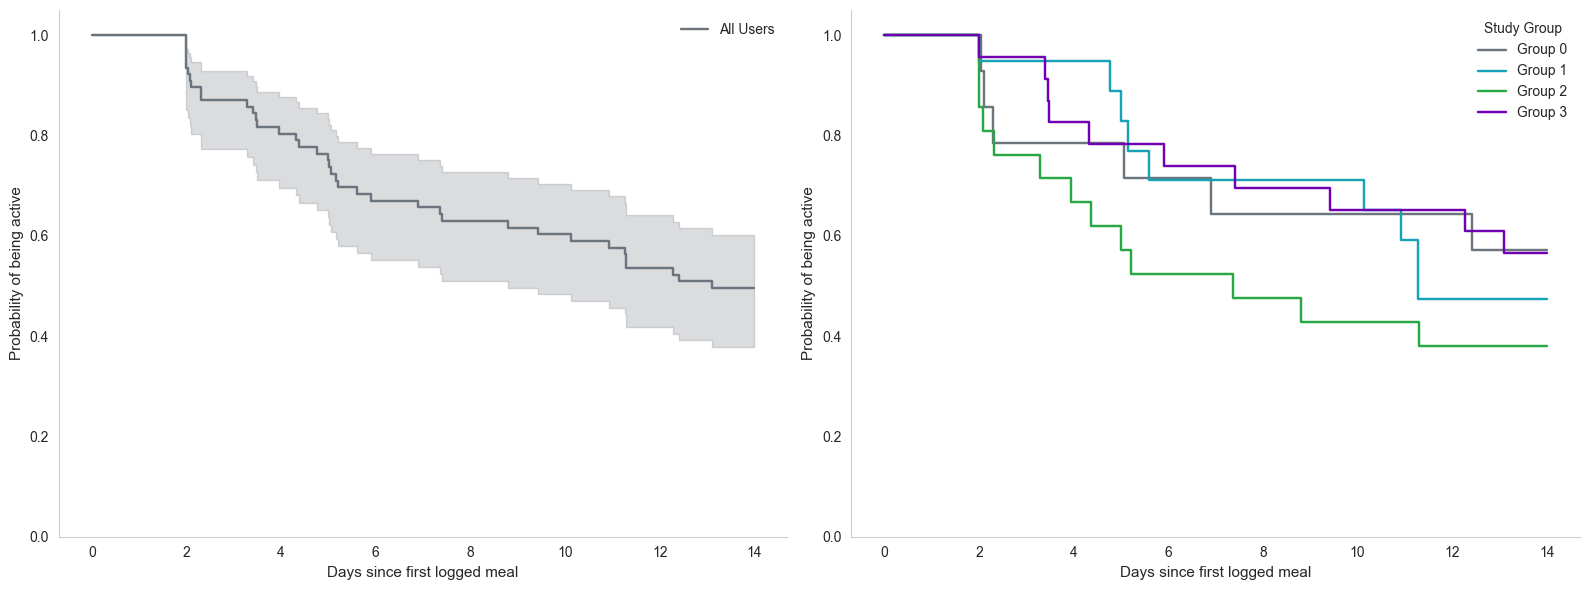

In [19]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, statistics
import matplotlib.pyplot as plt
import seaborn as sns



# ------------------------
# PARAMETERS (Modulable)
# ------------------------
INACTIVITY_THRESHOLD_DAYS = 2
STUDY_DURATION_DAYS = 14    

meals_df['datetime'] = pd.to_datetime(meals_df['datetime'])

# Filter to users who have logged at least one meal
active_user_ids = meals_df['user_id'].unique()
users_df = users_df[users_df['user_id'].isin(active_user_ids)].copy()

# ------------------------
# CALCULATE TIME TO EVENT PER USER
# ------------------------
threshold = pd.Timedelta(days=INACTIVITY_THRESHOLD_DAYS)

records = []

for _, user in users_df.iterrows():
    uid = user['user_id']
    group = user['study_group']
    withdrawal = user['withdrawal']
    
    user_meals = meals_df[meals_df['user_id'] == uid].sort_values('datetime')
    meal_times = user_meals['datetime'].tolist()
    
    if len(meal_times) == 0:
        # Skip users with no meals (just in case)
        continue
    
    study_start = meal_times[0]
    study_end = study_start + pd.Timedelta(days=STUDY_DURATION_DAYS)
    
    event_occurred = 0
    event_time = None
    
    # Check gaps between consecutive meal logs for inactivity event
    for prev, next_ in zip(meal_times, meal_times[1:]):
        if next_ - prev > threshold:
            event_time = prev + threshold
            event_occurred = 1
            break
    else:
        # No inactivity gap found *between* meals
        last_meal = meal_times[-1]
        
        if withdrawal:
            # Withdrawn user ---> censor at last meal
            duration = (last_meal - study_start).total_seconds() / (3600*24)
            event_occurred = 0
        else:
            # Check gap from last meal to study end
            gap_to_end = study_end - last_meal
            if gap_to_end > threshold:
                # Event happened: user became inactive after last meal
                event_time = last_meal + threshold
                event_occurred = 1
                duration = (event_time - study_start).total_seconds() / (3600*24)
            else:
                # User stayed active until end ---> right-censored
                duration = (study_end - study_start).total_seconds() / (3600*24)
                event_occurred = 0
    
    # If event occurred in gaps between meals:
    if event_occurred == 1 and event_time is not None:
        duration = (event_time - study_start).total_seconds() / (3600*24)

    
    records.append({
        'user_id': uid,
        'duration': duration,
        'event': event_occurred,
        'study_group': group
    })

survival_df = pd.DataFrame.from_records(records)

print(f"Processed survival data for {len(survival_df)} users.")
print(survival_df.head())

# ------------------------
# PLOTTING TIME
# ------------------------
kmf = KaplanMeierFitter()
groups = sorted(survival_df['study_group'].unique())
colors = ['#6c757d', '#17a2b8', '#28a745', '#7100b3']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall survival curve (use first color or pick another)
kmf.fit(survival_df['duration'], event_observed=survival_df['event'], label='All Users')
kmf.plot(ci_show=True, ax=axes[0], color=colors[0])
axes[0].set_xlabel('Days since first logged meal')
axes[0].set_ylabel('Probability of being active')
axes[0].set_ylim(0, 1.05)
axes[0].grid(False)

# Plot 2: Survival curves per study group
for group, color in zip(groups, colors):
    mask = survival_df['study_group'] == group
    kmf.fit(survival_df.loc[mask, 'duration'], survival_df.loc[mask, 'event'], label=f'Group {group}')
    kmf.plot(ax=axes[1], ci_show=False, color=color)
#axes[1].set_title(f'Survival Curves by Study Group\n(Inactivity threshold = {INACTIVITY_THRESHOLD_DAYS} day(s))')
axes[1].set_xlabel('Days since first logged meal')
axes[1].set_ylabel('Probability of being active')  # Y-label already on first plot
axes[1].set_ylim(0, 1.05)
axes[1].grid(False)
axes[1].legend(title='Study Group')

print("\n" + "="*50)
print("STATISTICAL COMPARISON")
print("="*50)

# Log-rank test between groups (if more than one group)
if len(groups) > 1:
    try:
        # Pairwise comparisons
        from itertools import combinations
        
        for group1, group2 in combinations(groups, 2):
            mask1 = survival_df['study_group'] == group1
            mask2 = survival_df['study_group'] == group2
            
            durations1 = survival_df.loc[mask1, 'duration']
            events1 = survival_df.loc[mask1, 'event']
            durations2 = survival_df.loc[mask2, 'duration']
            events2 = survival_df.loc[mask2, 'event']
            
            # Log-rank test
            results = statistics.logrank_test(durations1, durations2, events1, events2)
            print(f"\nLog-rank test: Group {group1} vs Group {group2}")
            print(f"  Test statistic: {results.test_statistic:.3f}")
            print(f"  p-value: {results.p_value:.3f}")
            print(f"  Significant: {'Yes' if results.p_value < 0.05 else 'No'}")
            
    except Exception as e:
        print(f"Statistical testing failed: {e}")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")


plt.tight_layout()
plt.show()
last_meal_survival = survival_df

### 3.2 - Using 2+ eating occasions logged daily

Processed survival data for 79 users.
Event definition: 2 consecutive days with < 2 eating occasions per day
Eating occasions defined as: Breakfast (5-11h), Lunch (11-15h), Dinner (18-23h)

Survival data summary:
          user_id   duration      event  study_group  total_days_tracked  \
count   79.000000  79.000000  79.000000    79.000000                79.0   
mean    59.265823   8.784810   0.620253     1.721519                15.0   
std     33.480844   5.178038   0.488425     1.097044                 0.0   
min      3.000000   2.000000   0.000000     0.000000                15.0   
25%     27.500000   4.000000   0.000000     1.000000                15.0   
50%     63.000000  11.000000   1.000000     2.000000                15.0   
75%     89.500000  14.000000   1.000000     3.000000                15.0   
max    112.000000  14.000000   1.000000     3.000000                15.0   

       adherent_days  
count      79.000000  
mean        7.658228  
std         5.751000  
min       

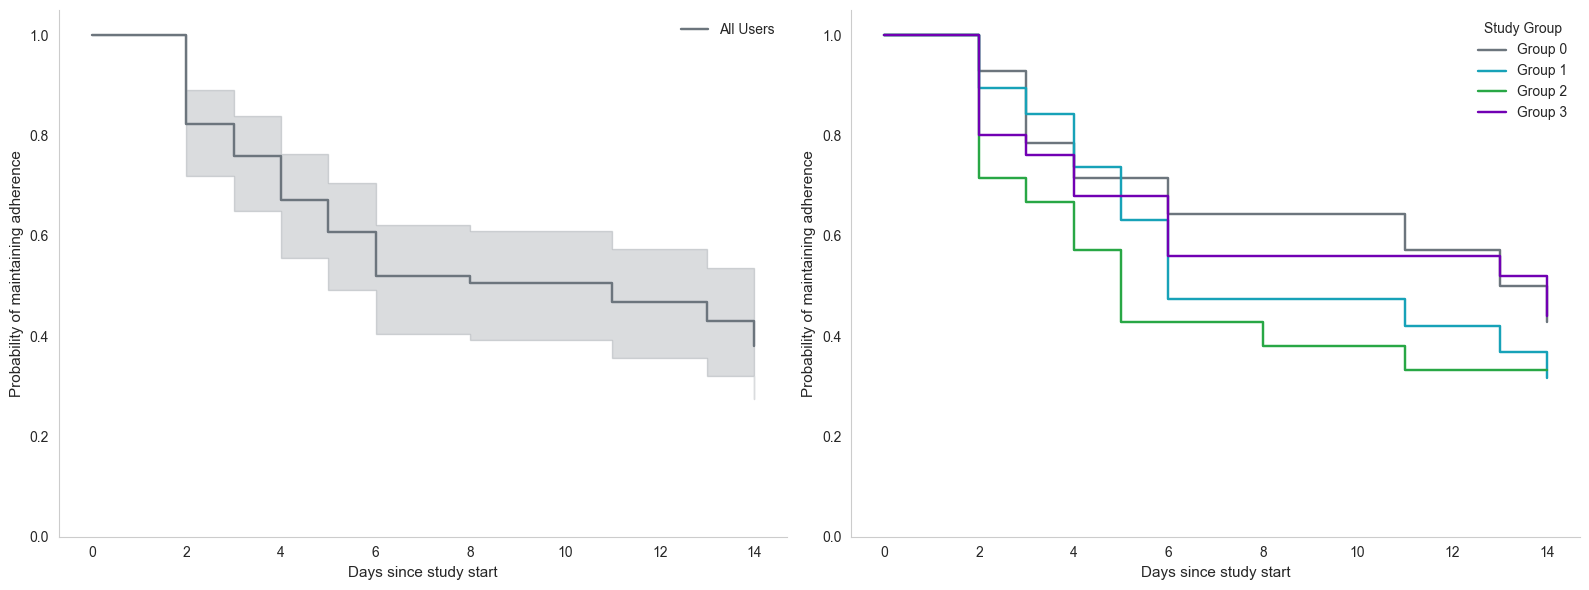


STATISTICAL COMPARISON

Log-rank test: Group 0 vs Group 1
  Test statistic: 0.440
  p-value: 0.507
  Significant: No

Log-rank test: Group 0 vs Group 2
  Test statistic: 0.814
  p-value: 0.367
  Significant: No

Log-rank test: Group 0 vs Group 3
  Test statistic: 0.002
  p-value: 0.968
  Significant: No

Log-rank test: Group 1 vs Group 2
  Test statistic: 0.167
  p-value: 0.683
  Significant: No

Log-rank test: Group 1 vs Group 3
  Test statistic: 0.481
  p-value: 0.488
  Significant: No

Log-rank test: Group 2 vs Group 3
  Test statistic: 0.940
  p-value: 0.332
  Significant: No


In [21]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, statistics
import matplotlib.pyplot as plt
import seaborn as sns


# ------------------------
# PARAMETERS (Modulable)
# ------------------------
CONSECUTIVE_DAYS_THRESHOLD = 2  # Failure after 2 consecutive days without 2+ eating occasions
STUDY_DURATION_DAYS = 14       # Total study duration considered per user
MIN_EATING_OCCASIONS_PER_DAY = 2  # Minimum eating occasions per day to be considered "adherent"

BREAKFAST_START = 5   # 5 AM
BREAKFAST_END = 11    # 11 AM
LUNCH_START = 11      # 11 AM
LUNCH_END = 15        # 3 PM
DINNER_START = 18     # 6 PM
DINNER_END = 23       # 11 PM

meals_df['datetime'] = pd.to_datetime(meals_df['datetime'])

# Filter to users who have logged at least one meal
active_user_ids = meals_df['user_id'].unique()
users_df = users_df[users_df['user_id'].isin(active_user_ids)].copy()

def classify_eating_occasion(hour):
    """Classify meal time into eating occasion based on hour of day"""
    if BREAKFAST_START <= hour < BREAKFAST_END:
        return 'Breakfast'
    elif LUNCH_START <= hour < LUNCH_END:
        return 'Lunch'
    elif DINNER_START <= hour < DINNER_END:
        return 'Dinner'
    else:
        return 'Other'

def calculate_daily_eating_occasions(user_meals):
    """Calculate number of eating occasions per day for a user"""
    user_meals = user_meals.copy()
    user_meals['hour'] = user_meals['datetime'].dt.hour
    user_meals['date'] = user_meals['datetime'].dt.date
    user_meals['eating_occasion'] = user_meals['hour'].apply(classify_eating_occasion)
    
    # Count unique eating occasions per day (excluding 'Other')
    valid_occasions = user_meals[user_meals['eating_occasion'] != 'Other']
    daily_occasions = valid_occasions.groupby('date')['eating_occasion'].nunique().reset_index()
    daily_occasions.columns = ['date', 'eating_occasions']
    
    return daily_occasions

# ------------------------
# CALCULATE TIME TO EVENT PER USER
# ------------------------
records = []

for _, user in users_df.iterrows():
    uid = user['user_id']
    group = user['study_group']
    withdrawal = user['withdrawal']
    
    user_meals = meals_df[meals_df['user_id'] == uid].sort_values('datetime')
    
    if len(user_meals) == 0:
        # Skip users with no meals 
        continue
    
    study_start = user_meals['datetime'].min().date()
    study_end = study_start + pd.Timedelta(days=STUDY_DURATION_DAYS)
    
    # Calculate daily eating occasions
    daily_occasions = calculate_daily_eating_occasions(user_meals)
    
    # Create complete date range for study period
    date_range = pd.date_range(start=study_start, end=study_end, freq='D')
    complete_days = pd.DataFrame({'date': date_range.date})
    
    # Merge with actual eating occasions data
    daily_data = complete_days.merge(daily_occasions, on='date', how='left')
    daily_data['eating_occasions'] = daily_data['eating_occasions'].fillna(0)
    daily_data['adherent'] = daily_data['eating_occasions'] >= MIN_EATING_OCCASIONS_PER_DAY
    
    # Find consecutive non-adherent days
    event_occurred = 0
    event_day = None
    consecutive_count = 0
    
    for i, row in daily_data.iterrows():
        if not row['adherent']:
            consecutive_count += 1
            if consecutive_count >= CONSECUTIVE_DAYS_THRESHOLD:
                # Event occurred: reached threshold of consecutive non-adherent days
                event_day = i - CONSECUTIVE_DAYS_THRESHOLD + 1  # Day when failure started
                event_occurred = 1
                break
        else:
            consecutive_count = 0  # Reset counter on adherent day
    
    # Calculate duration, accounting for threshold added to event time
    if event_occurred == 1:
        duration = event_day + CONSECUTIVE_DAYS_THRESHOLD
        duration = min(duration, STUDY_DURATION_DAYS)  # Cap at study duration
    else:
        if withdrawal:
            # Withdrawn user → censor at last meal day
            last_meal_date = user_meals['datetime'].max().date()
            duration = (last_meal_date - study_start).days
            event_occurred = 0
        else:
            # User completed study without event → right-censored
            duration = STUDY_DURATION_DAYS
            event_occurred = 0
    
    # Ensure duration is non-negative
    duration = max(0, duration)
    
    records.append({
        'user_id': uid,
        'duration': duration,
        'event': event_occurred,
        'study_group': group,
        'total_days_tracked': len(daily_data),
        'adherent_days': daily_data['adherent'].sum()
    })

survival_df = pd.DataFrame.from_records(records)

print(f"Processed survival data for {len(survival_df)} users.")
print(f"Event definition: {CONSECUTIVE_DAYS_THRESHOLD} consecutive days with < {MIN_EATING_OCCASIONS_PER_DAY} eating occasions per day")
print(f"Eating occasions defined as: Breakfast ({BREAKFAST_START}-{BREAKFAST_END}h), Lunch ({LUNCH_START}-{LUNCH_END}h), Dinner ({DINNER_START}-{DINNER_END}h)")
print("\nSurvival data summary:")
print(survival_df.describe())
print(f"\nEvent rate: {survival_df['event'].mean():.2%}")

# ------------------------
# ADDITIONAL SUMMARY STATISTICS
# ------------------------
print("\n" + "="*50)
print("SUMMARY BY STUDY GROUP")
print("="*50)
for group in sorted(survival_df['study_group'].unique()):
    group_data = survival_df[survival_df['study_group'] == group]
    print(f"\nGroup {group}:")
    print(f"  N = {len(group_data)}")
    print(f"  Event rate: {group_data['event'].mean():.2%}")
    print(f"  Mean adherent days: {group_data['adherent_days'].mean():.1f}")
    print(f"  Median survival time: {group_data['duration'].median():.1f} days")

# ------------------------
# plotting timeeeee
# ------------------------
kmf = KaplanMeierFitter()
groups = sorted(survival_df['study_group'].unique())
colors = ['#6c757d', '#17a2b8', '#28a745', '#7100b3']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall survival curve
kmf.fit(survival_df['duration'], event_observed=survival_df['event'], label='All Users')
kmf.plot(ci_show=True, ax=axes[0], color=colors[0])
#axes[0].set_title(f'Overall Adherence Survival Curve\n(Failure: {CONSECUTIVE_DAYS_THRESHOLD} consecutive days with <{MIN_EATING_OCCASIONS_PER_DAY} eating occasions)')
axes[0].set_xlabel('Days since study start')
axes[0].set_ylabel('Probability of maintaining adherence')
axes[0].grid(False)
axes[0].set_ylim(0, 1.05)

# Plot 2: Survival curves per study group
for group, color in zip(groups, colors):
    mask = survival_df['study_group'] == group
    kmf.fit(survival_df.loc[mask, 'duration'], survival_df.loc[mask, 'event'], label=f'Group {group}')
    kmf.plot(ax=axes[1], ci_show=False, color=color)
#axes[1].set_title(f'Adherence Survival by Study Group\n(Failure: {CONSECUTIVE_DAYS_THRESHOLD} consecutive days with <{MIN_EATING_OCCASIONS_PER_DAY} eating occasions)')
axes[1].set_xlabel('Days since study start')
axes[1].set_ylabel('Probability of maintaining adherence')
axes[1].set_ylim(0, 1.05)
axes[1].legend(title='Study Group')
axes[1].grid(False)

plt.tight_layout()
plt.show()

# ------------------------
# statistics time
# ------------------------
print("\n" + "="*50)
print("STATISTICAL COMPARISON")
print("="*50)

# Log-rank test between groups
if len(groups) > 1:
    try:
        # Pairwise comparisons
        from itertools import combinations
        
        for group1, group2 in combinations(groups, 2):
            mask1 = survival_df['study_group'] == group1
            mask2 = survival_df['study_group'] == group2
            
            durations1 = survival_df.loc[mask1, 'duration']
            events1 = survival_df.loc[mask1, 'event']
            durations2 = survival_df.loc[mask2, 'duration']
            events2 = survival_df.loc[mask2, 'event']
            
            # Log-rank test
            results = statistics.logrank_test(durations1, durations2, events1, events2)
            print(f"\nLog-rank test: Group {group1} vs Group {group2}")
            print(f"  Test statistic: {results.test_statistic:.3f}")
            print(f"  p-value: {results.p_value:.3f}")
            print(f"  Significant: {'Yes' if results.p_value < 0.05 else 'No'}")
            
    except Exception as e:
        print(f"Statistical testing failed: {e}")


survival_eating_occasions = survival_df

### 3.3 - Using 50% of daily calories logged

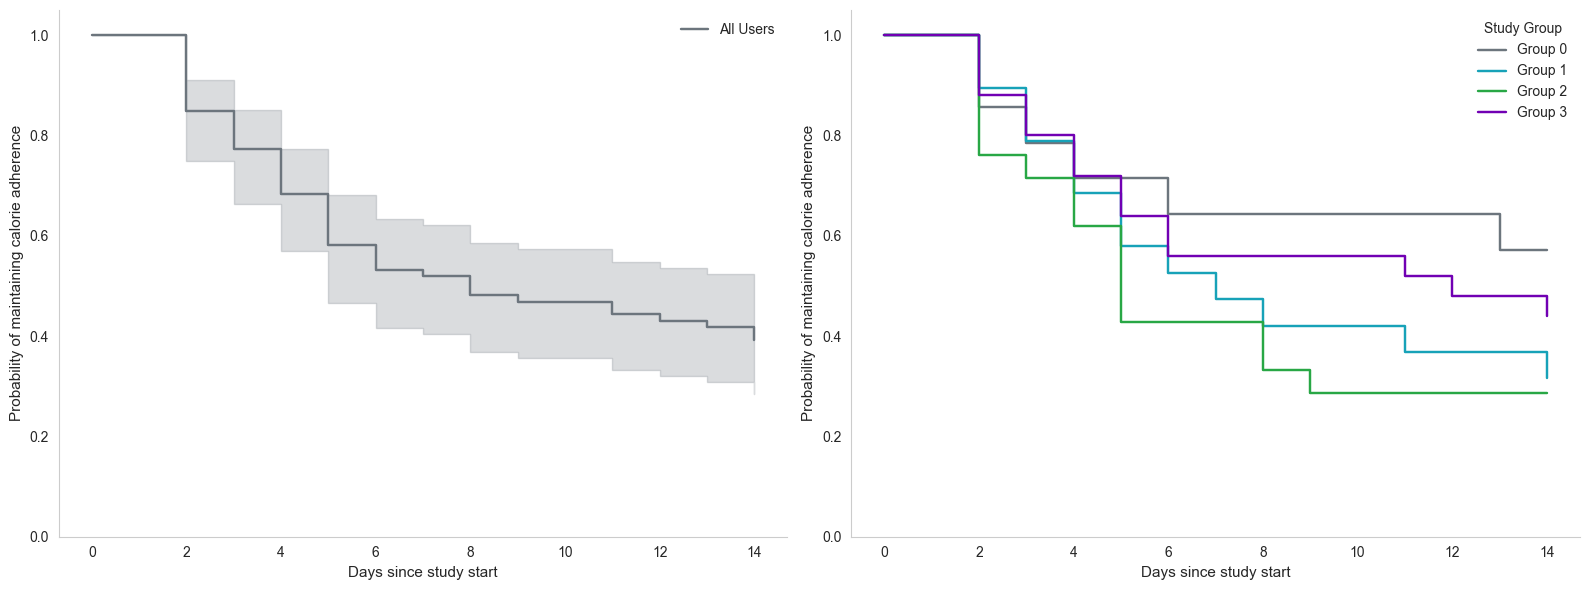


STATISTICAL COMPARISONS

Log-rank test: Group 0 vs Group 1
  Test statistic: 1.563
  p-value: 0.211
  Significant: No

Log-rank test: Group 0 vs Group 2
  Test statistic: 2.455
  p-value: 0.117
  Significant: No

Log-rank test: Group 0 vs Group 3
  Test statistic: 0.458
  p-value: 0.499
  Significant: No

Log-rank test: Group 1 vs Group 2
  Test statistic: 0.192
  p-value: 0.661
  Significant: No

Log-rank test: Group 1 vs Group 3
  Test statistic: 0.573
  p-value: 0.449
  Significant: No

Log-rank test: Group 2 vs Group 3
  Test statistic: 1.508
  p-value: 0.219
  Significant: No


In [22]:
# survival_analysis_calorie_adherence_transparent.ipynb

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, statistics
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# PARAMETERS (Modulable)
# ------------------------
MIN_DAILY_CALORIES_THRESHOLD = 0.5  # Minimum proportion of expected daily calories (50%)
CONSECUTIVE_FAILURE_DAYS = 2         # Number of consecutive days below threshold to consider failure
STUDY_DURATION_DAYS = 14             # Total study duration considered per user

def get_daily_calorie_needs(age, gender):
    """
    Calculate daily calorie needs based on the EFSA values used in
    the rest of the project
    
    Lower thresholds used:
    - Women 18-29: 1900 kcal/day
    - Women 30-59: 1800 kcal/day  
    - Women 60+: 1600 kcal/day
    - Men 18-29: 2300 kcal/day
    - Men 30-39: 2250 kcal/day
    - Men 40-49: 2200 kcal/day
    - Men 50+: 2000 kcal/day
    
    We use conservative estimates within these ranges.
    """
    if gender == 'M':
        if age <= 29:
            return 2300 
        elif age <= 39:
            return 2250  
        elif age <=49:
            return 2200  
        else:
            return 2000
    else: 
        if age <= 29:
            return 1900 
        elif age <= 59:
            return 1800
        else:
            return 1600

# Assume users_df and meals_df are already loaded in the notebook
meals_df['datetime'] = pd.to_datetime(meals_df['datetime'])
meals_df['energy_kcal'] = meals_df['nutrients'].apply(lambda x: x.get('energy_kcal'))

# ------------------------
# PREPROCESSING
# ------------------------
active_user_ids = meals_df['user_id'].unique()
users_df = users_df[users_df['user_id'].isin(active_user_ids)].copy()

# ------------------------
# CALCULATE TRANSPARENT DAILY CALORIE NEEDS
# ------------------------
users_df['expected_daily_calories'] = users_df.apply(
    lambda row: get_daily_calorie_needs(row['age'], row['gender']),
    axis=1
)

records = []

for _, user in users_df.iterrows():
    uid = user['user_id']
    group = user['study_group']
    withdrawal = user['withdrawal']
    expected_calories = user['expected_daily_calories']
    min_daily_calories = expected_calories * MIN_DAILY_CALORIES_THRESHOLD
    
    user_meals = meals_df[meals_df['user_id'] == uid].sort_values('datetime')
    if len(user_meals) == 0:
        continue

    study_start = user_meals['datetime'].iloc[0].normalize()
    study_end = study_start + pd.Timedelta(days=STUDY_DURATION_DAYS)

    user_meals['date'] = user_meals['datetime'].dt.date
    daily_calories = user_meals.groupby('date')['energy_kcal'].sum().reset_index()
    daily_calories['date'] = pd.to_datetime(daily_calories['date'])

    date_range = pd.date_range(start=study_start, end=study_end - pd.Timedelta(days=1), freq='D')
    complete_daily_df = pd.DataFrame({'date': date_range})

    daily_summary = complete_daily_df.merge(daily_calories, on='date', how='left')
    daily_summary['energy_kcal'] = daily_summary['energy_kcal'].fillna(0)
    daily_summary['meets_threshold'] = daily_summary['energy_kcal'] >= min_daily_calories

    # Same failure detection logic as before
    event_occurred = 0
    duration = None
    consecutive_failures = 0
    
    if not daily_summary['meets_threshold'].any():
        event_occurred = 1
        duration = 2
        failure_reason = "Never met threshold"
    else:
        failure_reason = "No failure"
        for i, row in daily_summary.iterrows():
            current_day = i + 1
            
            if not row['meets_threshold']:
                consecutive_failures += 1
                if consecutive_failures >= CONSECUTIVE_FAILURE_DAYS:
                    event_occurred = 1
                    duration = current_day
                    failure_reason = f"Failed on day {current_day} ({consecutive_failures} consecutive failures)"
                    break
            else:
                consecutive_failures = 0

        if event_occurred == 0:
            n_logged_days = (daily_summary['energy_kcal'] > 0).sum()
            
            if n_logged_days < CONSECUTIVE_FAILURE_DAYS:
                last_meal_date = user_meals['datetime'].max().normalize()
                duration = (last_meal_date - study_start).days + 1
                failure_reason = f"Censored - insufficient data ({n_logged_days} days logged)"
            elif withdrawal:
                last_meal_date = user_meals['datetime'].max().normalize()
                duration = (last_meal_date - study_start).days + 1
                failure_reason = f"Censored - withdrawal on day {duration}"
            else:
                duration = STUDY_DURATION_DAYS
                failure_reason = "Censored - completed study"

    duration = max(0, duration)

    records.append({
        'user_id': uid,
        'duration': duration,
        'event': event_occurred,
        'study_group': group,
        'expected_daily_calories': expected_calories,
        'min_daily_calories': min_daily_calories,
        'avg_daily_calories': daily_summary['energy_kcal'].mean(),
        'days_above_threshold': daily_summary['meets_threshold'].sum(),
        'failure_reason': failure_reason,
        'total_logged_days': (daily_summary['energy_kcal'] > 0).sum()
    })

survival_df = pd.DataFrame.from_records(records)


# ------------------------
# SIDE-BY-SIDE PLOTS
# ------------------------
kmf = KaplanMeierFitter()
groups = sorted(survival_df['study_group'].unique())
colors = ['#6c757d', '#17a2b8', '#28a745', '#7100b3']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall survival curve
kmf.fit(survival_df['duration'], event_observed=survival_df['event'], label='All Users')
kmf.plot(ci_show=True, ax=axes[0], color=colors[0])
#axes[0].set_title(f'Overall Adherence Survival Curve\n(EFSA Guidelines-based thresholds, {MIN_DAILY_CALORIES_THRESHOLD*100:.0f}% threshold, {CONSECUTIVE_FAILURE_DAYS} consecutive failure days)')
axes[0].set_xlabel('Days since study start')
axes[0].set_ylabel('Probability of maintaining calorie adherence')
axes[0].grid(False)
axes[0].set_ylim(0, 1.05)

# Plot 2: By study group
for group, color in zip(groups, colors):
    mask = survival_df['study_group'] == group
    kmf.fit(survival_df.loc[mask, 'duration'], survival_df.loc[mask, 'event'], label=f'Group {group}')
    kmf.plot(ax=axes[1], ci_show=False, color=color)
#axes[1].set_title(f'Adherence Survival Curves by Study Group\n(EFSA Guidelines-based thresholds, {MIN_DAILY_CALORIES_THRESHOLD*100:.0f}% threshold, {CONSECUTIVE_FAILURE_DAYS} consecutive failure days)')
axes[1].set_xlabel('Days since study start')
axes[1].legend(title='Study Group')
axes[1].set_ylabel('Probability of maintaining calorie adherence')
axes[1].grid(False)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

# ------------------------
# DETAILED ANALYSIS BY GROUP
# ------------------------
#print("\n" + "="*60)
#print("ADHERENCE STATISTICS BY GROUP")
#print("="*60)
#
#for group in groups:
#    group_data = survival_df[survival_df['study_group'] == group]
#    never_met_in_group = group_data[group_data['failure_reason'] == 'Never met threshold']
#    
#    print(f"\nGroup {group}:")
#    print(f"  Total users: {len(group_data)}")
#    print(f"  Failed adherence: {group_data['event'].sum()} ({group_data['event'].mean()*100:.1f}%)")
#    print(f"  Never met threshold: {len(never_met_in_group)} ({len(never_met_in_group)/len(group_data)*100:.1f}%)")
#    print(f"  Mean survival time: {group_data['duration'].mean():.1f} days")
#    print(f"  Median survival time: {group_data['duration'].median():.1f} days")
#    print(f"  Mean expected daily calories: {group_data['expected_daily_calories'].mean():.0f} kcal")
#    print(f"  Mean minimum threshold: {group_data['min_daily_calories'].mean():.0f} kcal")
#    print(f"  Mean actual daily calories: {group_data['avg_daily_calories'].mean():.0f} kcal")
#    print(f"  Mean days above threshold: {group_data['days_above_threshold'].mean():.1f} days")
#    print(f"  Mean total logged days: {group_data['total_logged_days'].mean():.1f} days")

# ------------------------
# STATISTICAL TESTS
# ------------------------
print("\n" + "="*60)
print("STATISTICAL COMPARISONS")
print("="*60)

if len(groups) > 1:
    try:
        # Pairwise comparisons
        from itertools import combinations
        
        for group1, group2 in combinations(groups, 2):
            mask1 = survival_df['study_group'] == group1
            mask2 = survival_df['study_group'] == group2
            
            durations1 = survival_df.loc[mask1, 'duration']
            events1 = survival_df.loc[mask1, 'event']
            durations2 = survival_df.loc[mask2, 'duration']
            events2 = survival_df.loc[mask2, 'event']
            
            # Log-rank test
            results = statistics.logrank_test(durations1, durations2, events1, events2)
            print(f"\nLog-rank test: Group {group1} vs Group {group2}")
            print(f"  Test statistic: {results.test_statistic:.3f}")
            print(f"  p-value: {results.p_value:.3f}")
            print(f"  Significant: {'Yes' if results.p_value < 0.05 else 'No'}")
            
    except Exception as e:
        print(f"Statistical testing failed: {e}")

# Additional validation
#print("\n" + "="*60)
#print("DATA VALIDATION")
#print("="*60)
#
#print(f"\nValidation checks:")
#print(f"1. All durations ≥ 1 day: {(survival_df['duration'] >= 1).all()}")
#print(f"2. All events are 0 or 1: {survival_df['event'].isin([0, 1]).all()}")
#print(f"3. Users with duration=1 and event=1 (never met threshold): {len(survival_df[(survival_df['duration'] == 1) & (survival_df['event'] == 1)])}")
#print(f"4. Maximum duration: {survival_df['duration'].max()} days")
#print(f"5. Minimum duration: {survival_df['duration'].min()} days")
#
## Show some examples of different failure patterns
#print(f"\nExample cases:")
#examples = survival_df.sample(min(5, len(survival_df)))
#for _, row in examples.iterrows():
#    print(f"User {row['user_id']} (Group {row['study_group']}): {row['failure_reason']}, Duration: {row['duration']} days")
#
calories_survival = survival_df

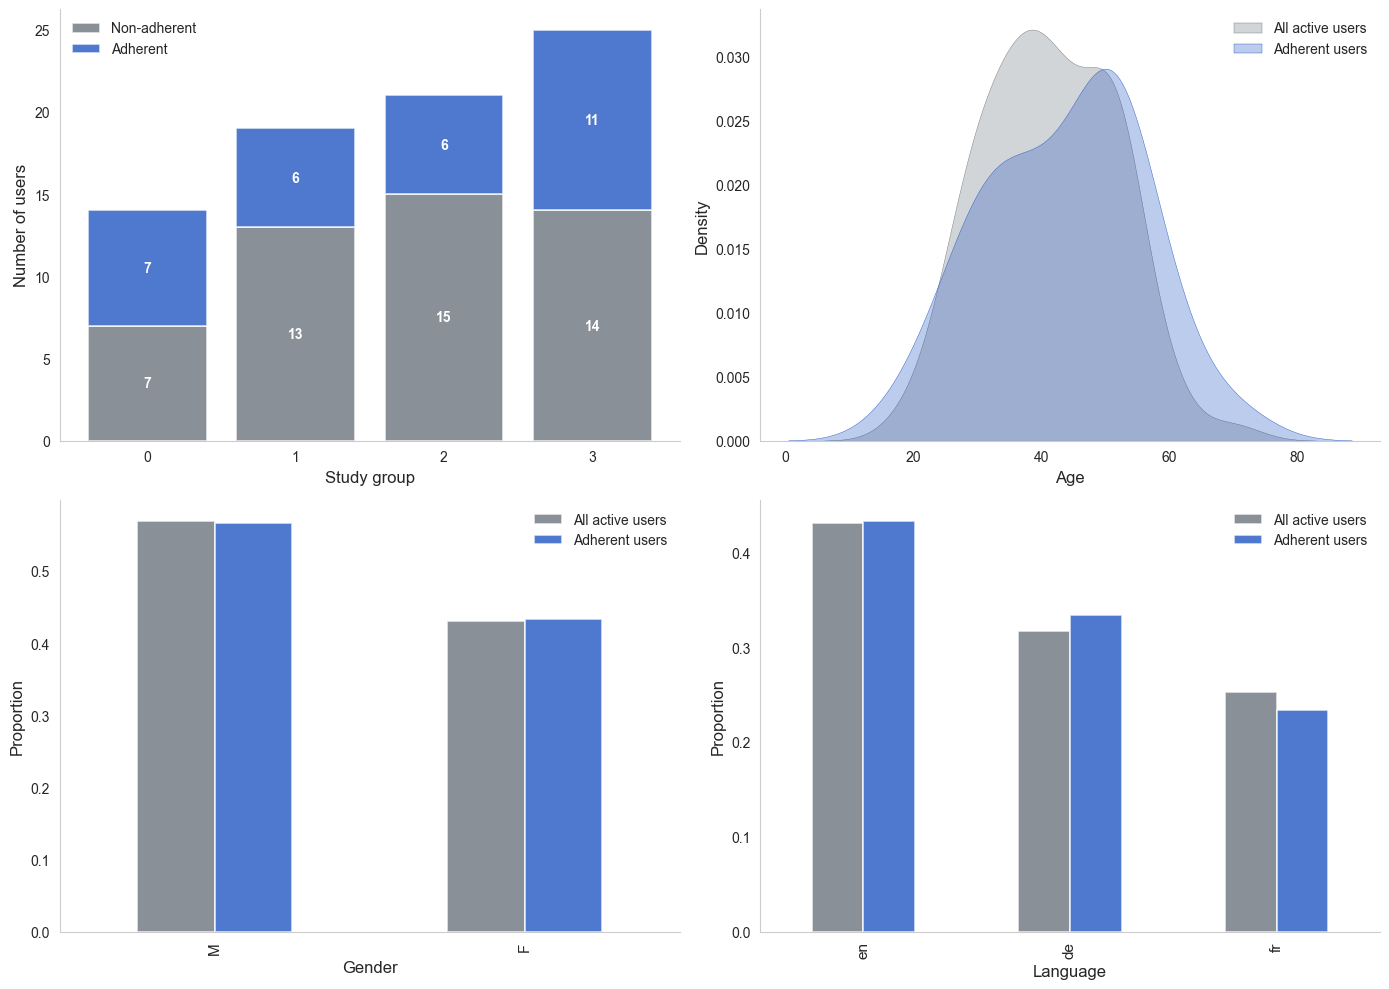

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: define adherent_users set (replace with your real list)
# adherent_users = {4, 7}
users_last_meal = set(last_meal_survival[last_meal_survival['duration'] == 14]['user_id'])
users_calories = set(calories_survival[calories_survival['duration'] == 14]['user_id'])
users_eating_occasions = set(survival_eating_occasions[survival_eating_occasions['duration'] == 14]['user_id'])

adherent_users = users_last_meal & users_calories & users_eating_occasions

# Filter adherent users
adherent_df = users_df[users_df['user_id'].isin(adherent_users)]

# Compute non-adherent users
non_adherent_df = users_df[~users_df['user_id'].isin(adherent_users)]

# Plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['axes.linewidth'] = 0.8

colors = ['#6c757d', "#2356c4"]

# Create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Study group adherence stacked bar
study_groups = sorted(users_df['study_group'].unique())

adherent_counts = adherent_df['study_group'].value_counts().reindex(study_groups, fill_value=0)
non_adherent_counts = non_adherent_df['study_group'].value_counts().reindex(study_groups, fill_value=0)

bottom = non_adherent_counts

bars1 = axes[0,0].bar(study_groups, non_adherent_counts, color=colors[0], alpha=0.8, edgecolor='white', linewidth=1.2, label='Non-adherent')
bars2 = axes[0,0].bar(study_groups, adherent_counts, bottom=non_adherent_counts, color=colors[1], alpha=0.8, edgecolor='white', linewidth=1.2, label='Adherent')

# Add numbers inside bars
for bar, count in zip(bars1, non_adherent_counts):
    if count > 0:
        axes[0,0].text(bar.get_x() + bar.get_width()/2., count/2, str(int(count)), ha='center', va='center', color='white', fontweight='bold', fontsize=10)
for bar, count, bottom_val in zip(bars2, adherent_counts, non_adherent_counts):
    if count > 0:
        axes[0,0].text(bar.get_x() + bar.get_width()/2., bottom_val + count/2, str(int(count)), ha='center', va='center', color='white', fontweight='bold', fontsize=10)

axes[0,0].set_xlabel('Study group', fontsize=12)
axes[0,0].set_ylabel('Number of users', fontsize=12)
axes[0,0].set_xticks(study_groups)
axes[0,0].legend()

# Age distribution KDE
sns.kdeplot(users_df['age'], fill=True, alpha=0.3, label='All active users', ax=axes[0,1], color=colors[0])
sns.kdeplot(adherent_df['age'], fill=True, alpha=0.3, label='Adherent users', ax=axes[0,1], color=colors[1])
axes[0,1].set_xlabel('Age', fontsize=12)
axes[0,1].set_ylabel('Density', fontsize=12)
axes[0,1].legend()

# Gender distribution
gender_counts_all = users_df['gender'].value_counts(normalize=True)
gender_counts_adherent = adherent_df['gender'].value_counts(normalize=True)

gender_df = pd.DataFrame({
    'All active users': gender_counts_all,
    'Adherent users': gender_counts_adherent
}).fillna(0)

gender_df.plot(kind='bar', ax=axes[1,0], color=colors, alpha=0.8, edgecolor='white', linewidth=1.2)
axes[1,0].set_xlabel('Gender', fontsize=12)
axes[1,0].set_ylabel('Proportion', fontsize=12)
axes[1,0].tick_params(axis='x', labelsize=11)
axes[1,0].legend()

# Language distribution
lang_counts_all = users_df['language'].value_counts(normalize=True)
lang_counts_adherent = adherent_df['language'].value_counts(normalize=True)

lang_df = pd.DataFrame({
    'All active users': lang_counts_all,
    'Adherent users': lang_counts_adherent
}).fillna(0)

lang_df.plot(kind='bar', ax=axes[1,1], color=colors, alpha=0.8, edgecolor='white', linewidth=1.2)
axes[1,1].set_xlabel('Language', fontsize=12)
axes[1,1].set_ylabel('Proportion', fontsize=12)
axes[1,1].tick_params(axis='x', labelsize=11)
axes[1,1].legend()

plt.tight_layout()
plt.show()


## User statisfaction

In [25]:
from src.utils.email_utils import get_users_adresses
feedback_results = pd.read_csv('../data/feedback_results.csv')
feedback_results.rename(columns={'E-mail address':'E-mail Address'}, inplace=True)
users_adresses = get_users_adresses()
users_adresses['E-mail Address'] = users_adresses['E-mail Address'].astype(str)
feedback_results['E-mail Address'] = feedback_results['E-mail Address'].str.lower()
users_adresses['E-mail Address'] = users_adresses['E-mail Address'].astype(str).str.lower()

# Merge (case-insensitive)
feedback_with_phone_numbers = feedback_results.merge(
    users_adresses,
    on='E-mail Address',
    how='left'
)
with app.app_context():
    users = get_all_users()

for idx, row in feedback_with_phone_numbers.iterrows():
    for user in users:
        if user.phone_number == row['Phone Number'] :
            feedback_with_phone_numbers.loc[idx, 'study_group'] = int(user.study_group)

In [26]:
grouped = feedback_with_phone_numbers.groupby('study_group').agg(lambda x: list(x))

html = "<html><body>"

for group, data in grouped.iterrows():
    html += f'<h2>Study Group: {group}</h2>'
    for col in feedback_with_phone_numbers.columns:
        if col not in ['study_group', 'Timestamp', 'E-mail Address', 'Phone Number']:  # skip metadata
            html += f'<h3>Question: {col}</h3><ul>'
            for i, answer in enumerate(data[col]):
                html += f'<li><strong>Response {i+1}:</strong> {answer}</li>'
            html += '</ul>'

html += "</body></html>"

# Optionally save to file
with open('grouped_feedback.html', 'w', encoding='utf-8') as f:
    f.write(html)

print("HTML file created: grouped_feedback.html")


HTML file created: grouped_feedback.html


Descriptive statistics by study group:

Question: How motivated did you feel to track your meals during the study ?
             count      mean       std  min  25%  50%   75%  max
study_group                                                     
0.0            3.0  4.333333  0.577350  4.0  4.0  4.0  4.50  5.0
1.0            8.0  3.875000  1.246423  1.0  4.0  4.0  4.25  5.0
2.0            5.0  4.200000  1.303840  2.0  4.0  5.0  5.00  5.0
3.0            8.0  4.125000  0.991031  2.0  4.0  4.0  5.00  5.0


Question: How well did the app's features adapt to your individual needs and preferences ?
             count      mean       std  min   25%  50%  75%  max
study_group                                                     
0.0            3.0  3.666667  1.154701  3.0  3.00  3.0  4.0  5.0
1.0            8.0  3.000000  0.534522  2.0  3.00  3.0  3.0  4.0
2.0            5.0  4.000000  0.707107  3.0  4.00  4.0  4.0  5.0
3.0            8.0  3.250000  1.035098  2.0  2.75  3.0  4.0  5.0


Question:

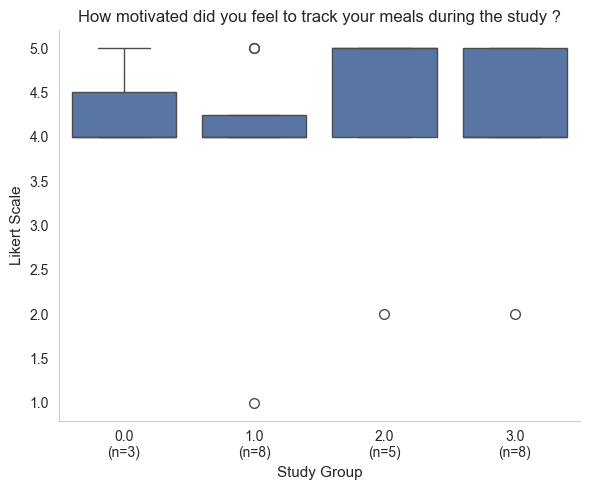

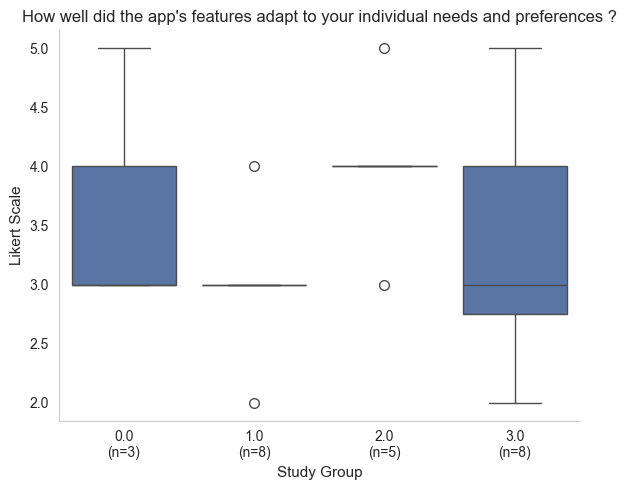

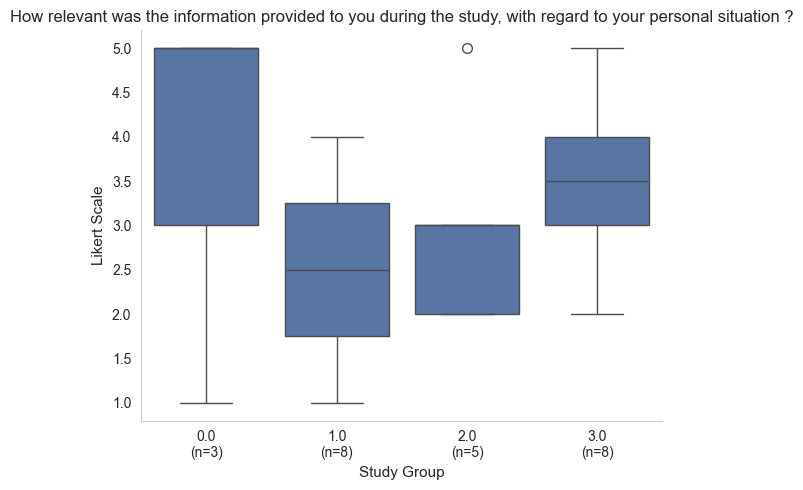

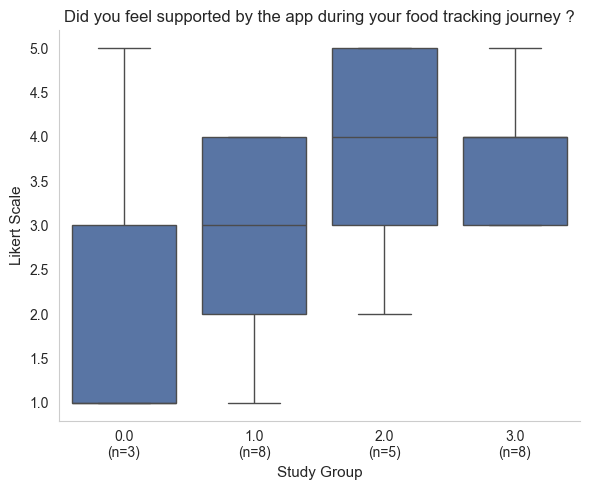

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# Select Likert-scale columns (adjust if needed)
likert_cols = [
    "How motivated did you feel to track your meals during the study ?",
    "How well did the app's features adapt to your individual needs and preferences ?",
    "How relevant was the information provided to you during the study, with regard to your personal situation ?",
    "Did you feel supported by the app during your food tracking journey ?"
]

# Convert to numeric (handle non-numeric gracefully)
for col in likert_cols:
    feedback_with_phone_numbers[col] = pd.to_numeric(feedback_with_phone_numbers[col], errors='coerce')

# Descriptive statistics by study group
print("Descriptive statistics by study group:\n")
for col in likert_cols:
    print(f"Question: {col}")
    print(feedback_with_phone_numbers.groupby('study_group')[col].describe())
    print("\n")

# Kruskal-Wallis tests
print("Kruskal-Wallis Test results:\n")
for col in likert_cols:
    groups = [group[col].dropna().values for name, group in feedback_with_phone_numbers.groupby('study_group')]
    stat, p = kruskal(*groups)
    print(f"{col} -> H-statistic: {stat:.3f}, p-value: {p:.4f}")

# Plot separate boxplots with number of respondents, ordered by group name
for col in likert_cols:
    # Count number of respondents per group
    counts = feedback_with_phone_numbers.groupby('study_group')[col].count()

    # Sort group names (convert to string for consistent labels)
    sorted_groups = sorted(counts.index, key=lambda x: str(x))

    # Create labels like "GroupName\n(n=XX)" in sorted order
    new_labels = [f"{group}\n(n={counts[group]})" for group in sorted_groups]

    # Map old group names to new labels
    label_map = dict(zip(sorted_groups, new_labels))

    # Create a copy and map to new labels
    plot_df = feedback_with_phone_numbers.copy()
    plot_df['study_group_labeled'] = plot_df['study_group'].map(label_map)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        x='study_group_labeled',
        y=col,
        data=plot_df,
        order=new_labels  # ensure order on x-axis
    )
    plt.title(col)
    plt.xlabel('Study Group')
    plt.ylabel('Likert Scale')
    plt.tight_layout()
    plt.show()
